In [1]:
import os
import random
import requests
from io import BytesIO
from PIL import Image

# --- CONFIGURATION ---
OUTPUT_DIR = "game_assets"

def get_memes_from_api():
    """
    Fetches the top 100 memes from Imgflip API.
    Returns a list of dictionaries: [{'id': '...', 'name': '...', 'url': '...'}, ...]
    """
    print("Connecting to Meme API...")
    try:
        url = "https://api.imgflip.com/get_memes"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data['data']['memes']
    except Exception as e:
        print(f"API Error: {e}")
        return []

def download_image(url):
    """
    Downloads an image using a 'fake' browser header to avoid 403 errors.
    """
    print(f"Downloading: {url}")
    
    # This dictionary makes the website think we are a Chrome browser, not a python script.
    fake_browser_headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=fake_browser_headers, timeout=10)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Download failed: {e}")
        return None

def generate_pixel_stages(original_img, meme_name):
    """Generates the pixel art clues."""
    
    # Clean the filename (remove slashes/weird characters)
    safe_name = "".join([c for c in meme_name if c.isalnum() or c in (' ', '_')]).strip()
    safe_name = safe_name.replace(" ", "_")
    
    meme_folder = os.path.join(OUTPUT_DIR, safe_name)
    if not os.path.exists(meme_folder):
        os.makedirs(meme_folder)

    width, height = original_img.size
    aspect_ratio = width / height
    
    # Stages: Very Pixelated (8px) -> Clearer (64px)
    resolutions = [8, 16, 32, 48, 64] 

    for i, target_width in enumerate(resolutions):
        target_height = int(target_width / aspect_ratio)
        
        # 1. Downsample (Crush quality)
        tiny_img = original_img.resize(
            (target_width, target_height), 
            resample=Image.BILINEAR
        )

        # 2. Upsample (Pixel Art Look)
        pixel_art_img = tiny_img.resize(
            (width, height), 
            resample=Image.NEAREST
        )
        
        save_path = os.path.join(meme_folder, f"clue_{i+1}.png")
        pixel_art_img.save(save_path)

    # Save the full resolution Answer
    original_img.save(os.path.join(meme_folder, "ANSWER.png"))
    print(f"Success! Generated assets for: {safe_name}")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Get the list of top 100 memes
    meme_list = get_memes_from_api()
    
    if meme_list:
        # 2. Pick a random one (RNG)
        # You can change k=1 to k=5 if you want to generate 5 batches at once
        selected_memes = random.choices(meme_list, k=1)
        
        for meme in selected_memes:
            print(f"\n--- Processing: {meme['name']} ---")
            
            # 3. Download
            img = download_image(meme['url'])
            
            # 4. Generate Art
            if img:
                generate_pixel_stages(img, meme['name'])
    else:
        print("Could not fetch meme list.")

Connecting to Meme API...

--- Processing: Blank Nut Button ---
Downloading: https://i.imgflip.com/1yxkcp.jpg
Success! Generated assets for: Blank_Nut_Button



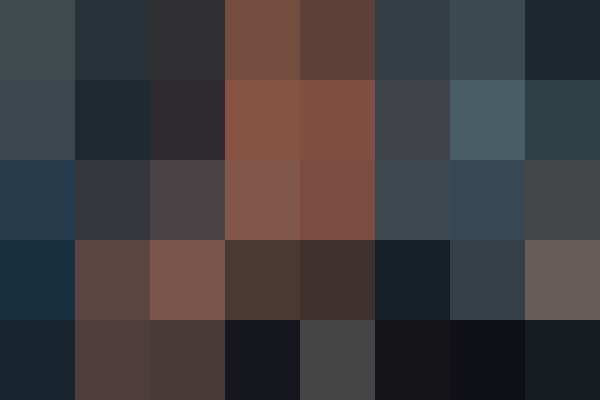
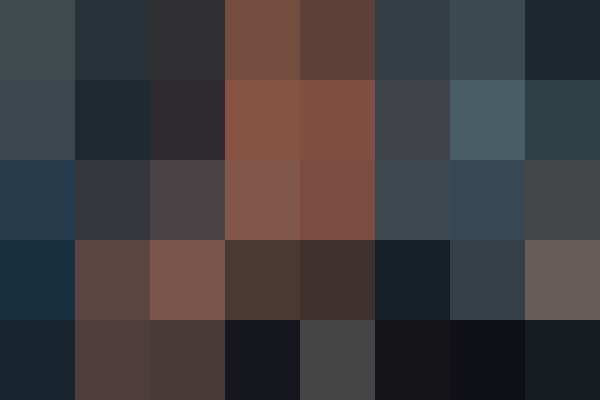
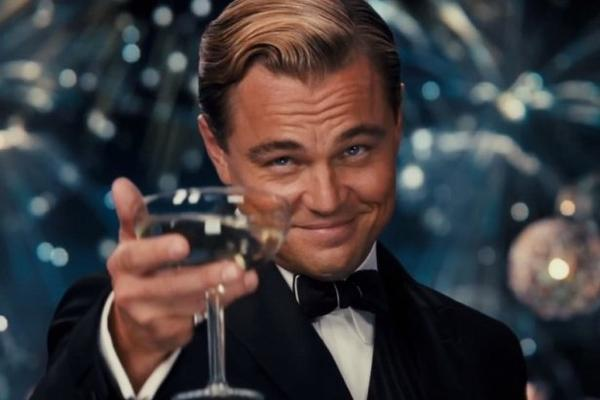
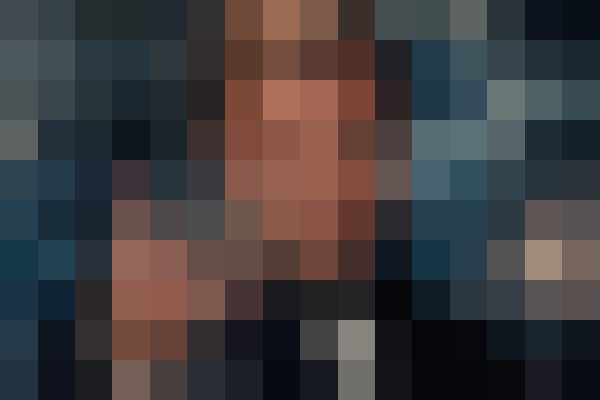
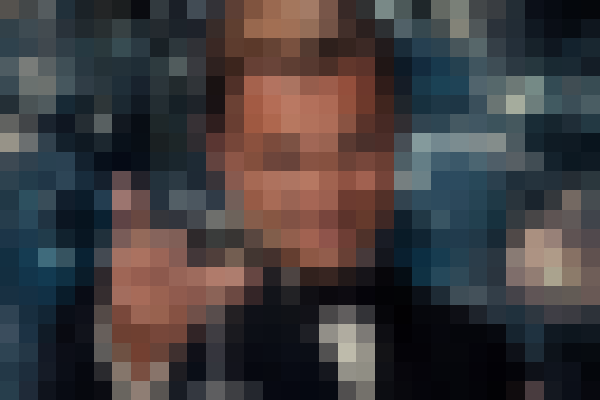
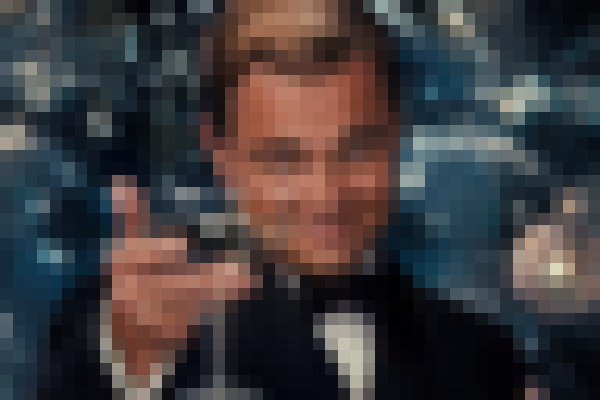
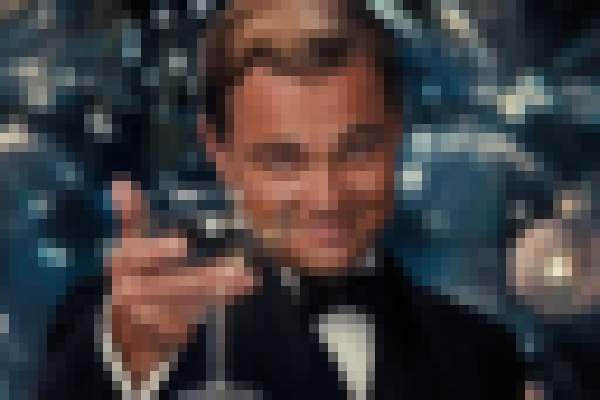

In [46]:
import os
import shutil
import base64
import json
import random
from IPython.display import HTML, display, clear_output

# --- CONFIGURATION ---
ASSETS_DIR = "game_assets"

# --- 1. CLEANUP & LOAD ---
def clean_and_load():
    if not os.path.exists(ASSETS_DIR): return None
    
    # Get all valid folders
    folders = [f for f in os.listdir(ASSETS_DIR) if os.path.isdir(os.path.join(ASSETS_DIR, f))]
    valid_folders = []
    
    # Filter out broken ones
    for f in folders:
        path = os.path.join(ASSETS_DIR, f)
        if os.path.exists(os.path.join(path, "clue_1.png")) and \
           os.path.exists(os.path.join(path, "ANSWER.png")):
            valid_folders.append(f)
            
    if not valid_folders: return None
    
    # Pick One
    chosen = random.choice(valid_folders)
    path = os.path.join(ASSETS_DIR, chosen)
    
    # Load Image Data
    def get_b64(fname):
        try:
            with open(os.path.join(path, fname), "rb") as f:
                return f"data:image/png;base64,{base64.b64encode(f.read()).decode('utf-8').replace(chr(10), '')}"
        except: return None

    images = {}
    img_1 = get_b64("clue_1.png")
    img_ans = get_b64("ANSWER.png")
    
    if not img_1 or not img_ans: return None
    
    images["1"] = img_1
    images["answer"] = img_ans
    
    # Fill gaps
    for i in range(2, 6):
        val = get_b64(f"clue_{i}.png")
        images[str(i)] = val if val else img_1
        
    return {
        "name": chosen.replace("_", " "),
        "clean_name": chosen.replace("_", " ").lower(),
        "images": images
    }

# --- 2. EXECUTE LOAD ---
clear_output(wait=True)
game_data = clean_and_load()

if game_data:
    json_payload = json.dumps(game_data)
    
    # --- 3. UI WITH LAYOUT FIXES ---
    html_code = f"""
    <!DOCTYPE html>
    <html>
    <head>
    <style>
        .pixel-card {{
            background: #202020; color: #fff;
            width: 500px; padding: 20px; margin: 20px auto;
            border-radius: 12px; font-family: 'Segoe UI', sans-serif; text-align: center;
            border: 1px solid #444; box-shadow: 0 10px 40px rgba(0,0,0,0.5);
            /* Prevent card from collapsing */
            min-height: 600px; 
            display: flex; flex-direction: column; justify-content: space-between;
        }}
        
        .img-frame {{
            /* FIXED DIMENSIONS */
            width: 100%; 
            max-width: 400px;
            height: 350px; /* Fixed height so controls never move */
            margin: 10px auto;
            background: #000; 
            border: 4px solid #333;
            
            /* KEY FIX: Center content and hide overflow */
            display: flex; align-items: center; justify-content: center;
            overflow: hidden; 
            position: relative;
        }}
        
        .game-img {{
            /* KEY FIX: Contain image inside the box */
            max-width: 100%;
            max-height: 100%;
            width: auto;
            height: auto;
            object-fit: contain; 
            image-rendering: pixelated; 
        }}

        .ui-area {{ margin-top: auto; padding-top: 10px; }}
        
        input {{ padding: 12px; width: 60%; font-size: 16px; border-radius: 6px; border: none; outline: none; margin-bottom: 10px; }}
        button {{ padding: 10px 15px; font-size: 14px; font-weight: bold; margin: 5px; border: none; border-radius: 4px; cursor: pointer; transition: 0.2s; }}
        button:hover {{ transform: scale(1.05); }}
        
        .btn-guess {{ background: #00e676; color: #003300; }}
        .btn-hint {{ background: #ffea00; color: #333; }}
        .btn-giveup {{ background: #ff3d00; color: white; }}
        .btn-reload {{ background: #2979ff; color: white; display: none; width: 80%; margin: 15px auto; padding: 12px; }}

    </style>
    </head>
    <body>

    <div class="pixel-card">
        <div>
            <div style="display:flex; justify-content:space-between; color:#888; font-size: 0.9em;">
                <span id="stage-txt">Stage 1/5</span>
                <span id="score-txt" style="color:#00e676">1000 Pts</span>
            </div>
            <h2 id="title-txt" style="margin: 10px 0;">Mystery Meme</h2>
        </div>
        
        <div class="img-frame">
            <img id="game-img" class="game-img" src="{game_data['images']['1']}">
        </div>

        <div class="ui-area" id="ui-controls">
            <input type="text" id="guess-inp" placeholder="Who is this?" onkeydown="if(event.key==='Enter') window.doGuess()">
            <br>
            <button class="btn-guess" onclick="window.doGuess()">GUESS</button>
            <div style="margin-top: 10px;">
                <button class="btn-hint" onclick="window.getHint()">Hint (-200)</button>
                <button class="btn-giveup" onclick="window.giveUp()">Give Up</button>
            </div>
        </div>
        
        <div id="feedback" style="height:25px; font-weight:bold; color:#ffea00; margin-top:10px;"></div>
        
        <button class="btn-reload" onclick="location.reload()">Play Again ⟳</button>
    </div>

    <script>
        (function() {{
            var data = {json_payload};
            var stage = 1;
            var score = 1000;
            var active = true;

            window.doGuess = function() {{
                if(!active) return;
                var inp = document.getElementById("guess-inp");
                var g = inp.value.trim().toLowerCase();
                if(!g) return;

                if(data.clean_name.includes(g) || g.includes(data.clean_name)) {{
                    endGame(true);
                }} else {{
                    msg("❌ Try again!", "#ff3d00");
                    inp.value = "";
                    score -= 50; // Wrong guess penalty
                    document.getElementById("score-txt").innerText = score + " Pts";
                }}
            }};

            window.getHint = function() {{
                if(!active || stage >= 5) return;
                stage++;
                score -= 200;
                document.getElementById("game-img").src = data.images[stage];
                document.getElementById("stage-txt").innerText = "Stage " + stage + "/5";
                document.getElementById("score-txt").innerText = score + " Pts";
            }};

            window.giveUp = function() {{ endGame(false); }};

            function endGame(win) {{
                active = false;
                document.getElementById("game-img").src = data.images["answer"];
                document.getElementById("title-txt").innerText = data.name;
                document.getElementById("ui-controls").style.display = "none";
                document.querySelector(".btn-reload").style.display = "block";
                msg(win ? "✅ CORRECT!" : "❌ GAME OVER", win ? "#00e676" : "#ff3d00");
            }}

            function msg(t, c) {{
                var el = document.getElementById("feedback");
                el.innerText = t;
                el.style.color = c;
            }}
        }})();
    </script>
    </body>
    </html>
    """
    display(HTML(html_code))
else:
    print("❌ Error: No valid game assets found. Run the generator script first.")